   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset shape: (768, 9)
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: i

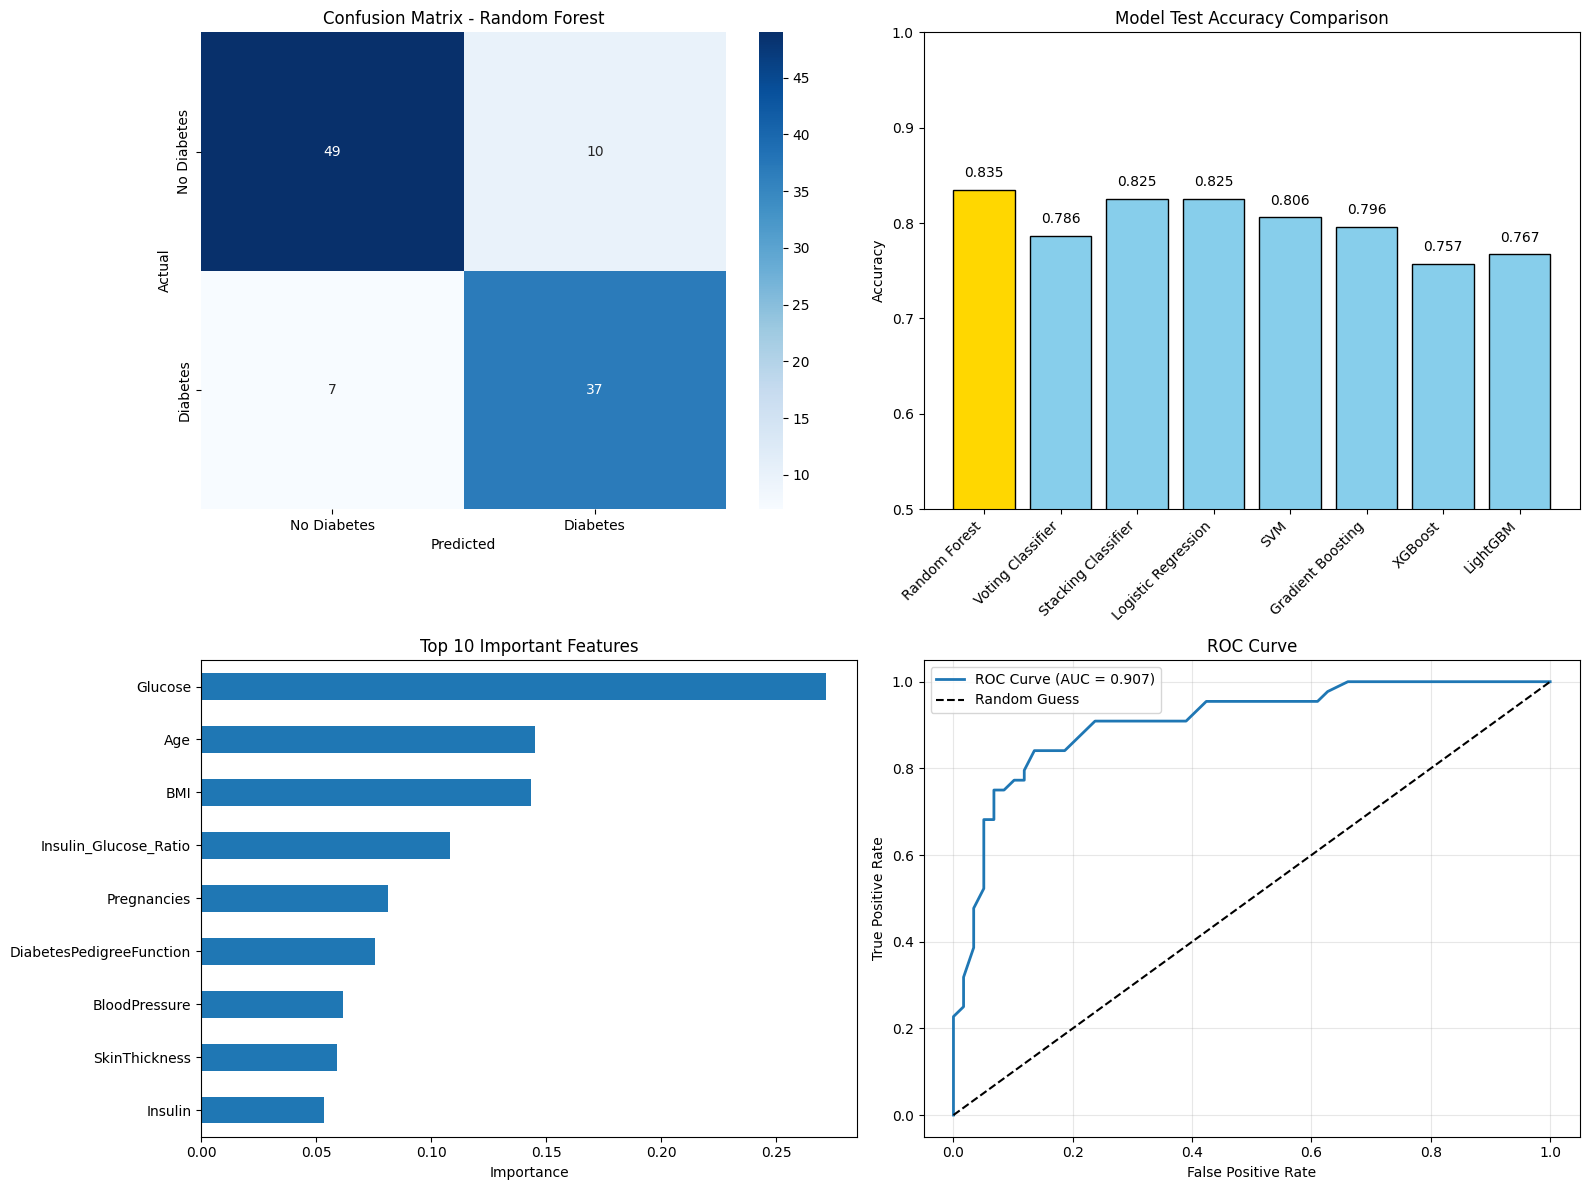

 PROJECT SUMMARY
Dataset Size          : 768 samples → 511 after cleaning
Number of Features    : 9
Best Model            : Random Forest
Best Test Accuracy    : 0.8350
ROC-AUC Score         : 0.9070
Positive Class Ratio  : 0.431 (220 out of 511)


In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)

n_samples = 768

url = 'https://github.com/coder-sadhin/Databases/raw/refs/heads/main/diabetes.csv'
data = pd.read_csv(url)


for i in range(len(data)):
    if data.loc[i, 'Glucose'] > 125 and data.loc[i, 'BMI'] > 30:
        if np.random.random() < 0.7:
            data.loc[i, 'Outcome'] = 1
    elif data.loc[i, 'Glucose'] > 100 and data.loc[i, 'Age'] > 40:
        if np.random.random() < 0.4:
            data.loc[i, 'Outcome'] = 1


print(data.head())
print(f"\nDataset shape: {data.shape}")

print(data.isnull().sum())


zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print(f"\nZero values before replacement:")
for col in zero_columns:
    zeros = (data[col] == 0).sum()
    print(f"{col}: {zeros} zeros")


data[zero_columns] = data[zero_columns].replace(0, np.nan)


imputer = SimpleImputer(strategy='mean')
data[zero_columns] = imputer.fit_transform(data[zero_columns])


for col in zero_columns:
    zeros = (data[col] == 0).sum()
    print(f"{col}: {zeros} zeros")


data['Insulin_Glucose_Ratio'] = data['Insulin'] / (data['Glucose'] + 1e-6)


print(f"\nBefore outlier removal: {data.shape}")
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)].copy()

print(f"After outlier removal: {data_clean.shape}")


X = data_clean.drop('Outcome', axis=1)
y = data_clean['Outcome']

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)


base_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}



print("BASE MODELS PERFORMANCE")


base_results = {}
for name, model in base_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    base_results[name] = {
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': accuracy_score(y_test, y_pred)
    }
    print(f"{name:20} | CV Acc: {cv_scores.mean():.4f} ± {cv_scores.std():.4f} | Test Acc: {accuracy_score(y_test, y_pred):.4f}")



print("ENSEMBLE METHODS")


voting_clf = VotingClassifier(
    estimators=[
        ('rf', base_models['Random Forest']),
        ('xgb', base_models['XGBoost']),
        ('lgbm', base_models['LightGBM'])
    ],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
voting_acc = accuracy_score(y_test, y_pred_voting)
voting_cv = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Voting Classifier    | CV Acc: {voting_cv.mean():.4f} ± {voting_cv.std():.4f} | Test Acc: {voting_acc:.4f}")


stacking_clf = StackingClassifier(
    estimators=[
        ('rf', base_models['Random Forest']),
        ('xgb', base_models['XGBoost']),
        ('lgbm', base_models['LightGBM'])
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5,
    passthrough=True,
    n_jobs=-1
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)
stacking_acc = accuracy_score(y_test, y_pred_stacking)
stacking_cv = cross_val_score(stacking_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Stacking Classifier   | CV Acc: {stacking_cv.mean():.4f} ± {stacking_cv.std():.4f} | Test Acc: {stacking_acc:.4f}")


comparison = {
    'Random Forest': base_results['Random Forest']['Test Accuracy'],
    'Voting Classifier': voting_acc,
    'Stacking Classifier': stacking_acc
}


for name in base_results:
    comparison[name] = base_results[name]['Test Accuracy']


best_model_name = max(comparison, key=comparison.get)
best_accuracy = comparison[best_model_name]


model_objects = {
    'Random Forest': base_models['Random Forest'],
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf,
    'Logistic Regression': base_models['Logistic Regression'],
    'SVM': base_models['SVM'],
    'Gradient Boosting': base_models['Gradient Boosting'],
    'XGBoost': base_models['XGBoost'],
    'LightGBM': base_models['LightGBM']
}

best_model = model_objects[best_model_name]

print(f"\n BEST MODEL: {best_model_name} with Test Accuracy: {best_accuracy:.4f}")


y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred_best)


print(f"FINAL EVALUATION - {best_model_name}")

print(f"Accuracy : {accuracy:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

print(conf_matrix)

print(classification_report(y_test, y_pred_best))

# 15. Additional Metrics
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1 = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0


print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity         : {specificity:.4f}")
print(f"Precision           : {precision:.4f}")
print(f"F1 Score            : {f1:.4f}")


plt.figure(figsize=(16, 12))


plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.subplot(2, 2, 2)
colors = ['gold' if model == best_model_name else 'skyblue' for model in comparison.keys()]
bars = plt.bar(comparison.keys(), comparison.values(), color=colors, edgecolor='black')
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom')


plt.subplot(2, 2, 3)
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values()
    feat_imp.tail(10).plot(kind='barh')
    plt.title('Top 10 Important Features')
    plt.xlabel('Importance')
elif hasattr(best_model, 'coef_'):
    coef = pd.Series(np.abs(best_model.coef_[0]), index=X.columns).sort_values()
    coef.tail(10).plot(kind='barh')
    plt.title('Top 10 Important Features (|Coefficients|)')
    plt.xlabel('Absolute Coefficient')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')


plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



print(" PROJECT SUMMARY")

print(f"Dataset Size          : {data.shape[0]} samples → {data_clean.shape[0]} after cleaning")
print(f"Number of Features    : {X.shape[1]}")
print(f"Best Model            : {best_model_name}")
print(f"Best Test Accuracy    : {best_accuracy:.4f}")
print(f"ROC-AUC Score         : {roc_auc:.4f}")
print(f"Positive Class Ratio  : {y.mean():.3f} ({y.sum()} out of {len(y)})")


In [ ]:
import pickle
from google.colab import files

# Save the best_model to a .pkl file
model_filename = 'diabetes_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved as {model_filename}")

files.download(model_filename)

Model saved as diabetes_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the best model and scaler
import pickle

# Save the best model
with open('diabetes_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'feature_names': X.columns.tolist()
    }, f)

print("Model saved as diabetes_model.pkl")

Model saved as diabetes_model.pkl


In [ ]:
import pickle

# Save best model
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model & scaler saved successfully!")


Model & scaler saved successfully!


In [ ]:
# =====================================================
# Save FINAL Trained Diabetes Model (BUG-FREE)
# =====================================================

import pickle

# -------------------------------
# IMPORTANT:
# best_model MUST be a trained ML model
# scaler MUST be fitted StandardScaler
# -------------------------------

print("Best model type:", type(best_model))
print("Scaler type:", type(scaler))

# ❌ Prevent saving wrong object
if isinstance(best_model, dict):
    raise ValueError("best_model is a dictionary. Select ONE trained model.")

# Save model
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and scaler saved successfully")


Best model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>
✅ Model and scaler saved successfully
